In [1]:
# 1. Import packages
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# 2. Load data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

d:\program\python\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [25]:
# 3. Create LeNet model
# 비교해보면 좋을 코드 1: https://www.youtube.com/watch?v=fcOW-Zyb5Bo
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 입력 이미지: 채널 1개, 출력 채널 6개, 5x5 정사각 convoluation layer
        # 5x5로 하면 에러나서 4x4의 convluation layer
        # padding을 바꿔도 됨
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1), padding=(0, 0))
        # 6개 채널, 16개 채널로 변환
        self.conv2 = nn.Conv2d(6, 16, kernel_size=4, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1) # default padding: 0, default stride: 1

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        # x = x.view(-1, 120)
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model.to(device)
print(next(model.parameters()))

Using cpu device
Parameter containing:
tensor([[[[ 0.1047, -0.0163,  0.1082,  0.2330],
          [-0.1238, -0.0171, -0.1885, -0.1406],
          [-0.1599, -0.0070, -0.1758, -0.1848],
          [-0.1018,  0.0348,  0.1518,  0.1586]]],


        [[[-0.1102, -0.2358,  0.0876,  0.0812],
          [ 0.0241,  0.1209,  0.0330, -0.0246],
          [-0.1026, -0.0312,  0.1346, -0.1026],
          [-0.1302, -0.0293, -0.1996, -0.1880]]],


        [[[-0.0157, -0.0423,  0.1303, -0.0719],
          [-0.2248, -0.0662,  0.1039, -0.2302],
          [ 0.0938, -0.1470,  0.1793,  0.0837],
          [ 0.0861,  0.0005, -0.1163, -0.1968]]],


        [[[-0.0182,  0.0051, -0.0422,  0.0783],
          [-0.1988,  0.0866,  0.0651, -0.0758],
          [-0.0983,  0.2203, -0.0400,  0.0905],
          [-0.1756, -0.2433, -0.1619,  0.1520]]],


        [[[ 0.0399, -0.0658,  0.0232,  0.1684],
          [ 0.2412, -0.1790, -0.0943, -0.0768],
          [-0.1617,  0.2076,  0.0428, -0.1546],
          [ 0.0383, -0.1388,  0.2

In [15]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 25, 25]             102
            Conv2d-2             [-1, 16, 9, 9]           1,552
            Conv2d-3            [-1, 120, 1, 1]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 43,508
Trainable params: 43,508
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [16]:
# reduction 'sum': 데이터의 loss가 너무 작을 때 사용. default average
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 147.445374  [    0/60000]
loss: 106.474106  [ 6400/60000]
loss: 101.045715  [12800/60000]
loss: 101.037827  [19200/60000]
loss: 101.972282  [25600/60000]
loss: 101.661926  [32000/60000]
loss: 99.746559  [38400/60000]
loss: 101.614075  [44800/60000]
loss: 98.514923  [51200/60000]
loss: 98.295296  [57600/60000]
Test Error: 
 Accuracy: 94.0%, Avg loss: 97.279851 

Epoch 2
-------------------------------
loss: 96.669487  [    0/60000]
loss: 97.450661  [ 6400/60000]
loss: 98.648758  [12800/60000]
loss: 97.410240  [19200/60000]
loss: 95.558647  [25600/60000]
loss: 97.741684  [32000/60000]
loss: 94.876572  [38400/60000]
loss: 98.802307  [44800/60000]
loss: 95.733788  [51200/60000]
loss: 97.017715  [57600/60000]
Test Error: 
 Accuracy: 96.1%, Avg loss: 95.681487 

Epoch 3
-------------------------------
loss: 95.003609  [    0/60000]
loss: 97.154594  [ 6400/60000]
loss: 96.684547  [12800/60000]
loss: 96.896324  [19200/60000]
loss: 94.835556  [25600

In [27]:
classes = [
    "0", "1", "2", "3", "4"
    "5", "6", "7", "8", "9"
]

model.eval()
x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    # x.unsqueeze(1): 가상으로 이미지개 여러개 있다고 바꿔줌. 이 경우, 3차원을 4차원으로 바꿔줌.
    # 즉 차원을 하나 높여줌
    pred = model(x.unsqueeze(1))
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([[0.0925, 0.0847, 0.0968, 0.0952, 0.1049, 0.1065, 0.1041, 0.1026, 0.1059,
         0.1068]])


IndexError: list index out of range

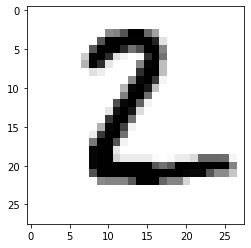

In [24]:
plt.imshow(x.reshape(28, 28), cmap='gist_yarg')